## Setup

In [1]:
# !pip install --upgrade --quiet pip
# !pip install --upgrade --quiet google-cloud-storage
# !pip install --upgrade --quiet google-cloud-documentai
# !pip install --upgrade --quiet google-cloud-aiplatform
# !pip install --upgrade --quiet vertexai

In [1]:
REGION = 'europe-west1'
PROJECT_ID = 'llmops-452409'
BUCKET = f"{PROJECT_ID}-bucket"

PROJECT_NUMBER_DETAILS = !gcloud projects describe $PROJECT_ID --format="value(projectNumber)"
PROJECT_NUMBER = PROJECT_NUMBER_DETAILS[0]

In [2]:
from google.cloud import aiplatform, bigquery
from datetime import datetime
from kfp import compiler, dsl #Kubeflow pipeline to build the pipeline in Vertex AI
from google.protobuf import json_format
from google.protobuf.struct_pb2 import Value
import json
import numpy as np

Create a bucket

In [3]:
!gsutil mb -l {REGION} gs://{BUCKET}

Creating gs://llmops-452409-bucket/...
ServiceException: 409 A Cloud Storage bucket named 'llmops-452409-bucket' already exists. Try another name. Bucket names must be globally unique across all Google Cloud projects, including those outside of your organization.


## Create a document AI processor

Get sample doc from git

In [4]:
!rm -r /content/gen-ai-on-google-cloud/
!git clone https://github.com/Sahilvohra58/gen-ai-on-google-cloud.git

rm: cannot remove '/content/gen-ai-on-google-cloud/': No such file or directory
fatal: destination path 'gen-ai-on-google-cloud' already exists and is not an empty directory.


NOTE: enable Cloud Document AI API in the GCP Console

In [5]:
from datetime import datetime
from google.api_core.client_options import ClientOptions
from google.cloud import documentai

UID = datetime.now().strftime("%m%d%H%M")

location = 'eu'
processor_display_name = f"RAG-Chunking-Processor-{UID}"
processor_type = 'LAYOUT_PARSER_PROCESSOR'

options = ClientOptions(api_endpoint=f"{location}-documentai.googleapis.com")
client = documentai.DocumentProcessorServiceClient(client_options = options)

parent = client.common_location_path(PROJECT_NUMBER, location)

processor = client.create_processor(
    parent=parent,
    processor=documentai.Processor(
        display_name=processor_display_name, type_=processor_type    
    ),
)

print(f"Processor Name: {processor.name}")
print(f"Processor Display Name: {processor.display_name}")
print(f"Processor Type: {processor.type_}")
print(f"Processor State: {processor.state}")

processor_name = processor.name

Processor Name: projects/200042228144/locations/eu/processors/57cf4f54293a2f3a
Processor Display Name: RAG-Chunking-Processor-03070526
Processor Type: LAYOUT_PARSER_PROCESSOR
Processor State: 1


## Parse documents into chuncks

In [6]:
from typing import Optional
from google.cloud import documentai_v1beta3 as documentai

#in Colab, change the file path to /content/Cinnamon.pdf
file_path = "/home/jupyter/gen-ai-on-google-cloud/Cinnamon.pdf"
mime_type = "application/pdf"

def process_document(
    project_id:str,
    location: str,
    processor_name: str,
    file_path:str,
    mime_type:str,
) -> None:
    options = ClientOptions(api_endpoint=f"{location}-documentai.googleapis.com")
    
    name = processor_name
    client = documentai.DocumentProcessorServiceClient(client_options=options)
    
    with open(file_path, "rb") as f:
        file_content = f.read()
        
    raw_document = documentai.RawDocument(content=file_content, mime_type=mime_type)
    
    process_options = documentai.ProcessOptions(
        layout_config=documentai.ProcessOptions.LayoutConfig(
            chunking_config=documentai.ProcessOptions.LayoutConfig.ChunkingConfig(
                chunk_size=200,
                include_ancestor_headings=True
            )
        )    
    )
    
    request = documentai.ProcessRequest(
        name = name,
        raw_document=raw_document,
        process_options=process_options,
    )
    #run the request and get the result document
    result = client.process_document(request=request)
    document = result.document
    return document

document_object = process_document(PROJECT_NUMBER, location, processor_name, file_path, mime_type)

doc_layout = document_object.document_layout
chunked_doc = document_object.chunked_document


Checkout the parsing output metadata

In [7]:
print(doc_layout.blocks[:2])

[block_id: "1"
text_block {
  text: "ASN"
  type_: "paragraph"
}
page_span {
  page_start: 1
  page_end: 1
}
, block_id: "2"
text_block {
  text: "EST. 1928"
  type_: "paragraph"
}
page_span {
  page_start: 1
  page_end: 1
}
]


Let's see some of the chucks

In [8]:
text_chunks = [chunk.content for chunk in chunked_doc.chunks]
# text_chunks = [truncate_chunk(chunk.content) if count_tokens(chunk.content) > MAX_TOKENS else chunk.content for chunk in chunked_doc.chunks]

# print(text_chunks[:5])

## Convert chunks into embeddings
1. Enable Vertex AI API in the project
2. Enable billing for the project, costs are low

Here we set the project id as environment variable and restart the kernel after that


In [9]:
import os
os.environ["GOOGLE_CLOUD_PROJECT"] = PROJECT_ID


In [11]:
from typing import List
from vertexai.language_models import TextEmbeddingInput, TextEmbeddingModel

def embed_text(
    texts: List[str] = text_chunks, # extracted chunks
    task: str= "RETRIEVAL_DOCUMENT",
    model_name: str="textembedding-gecko@003",    
) -> List[List[float]]:
    model = TextEmbeddingModel.from_pretrained(model_name)
    inputs = [TextEmbeddingInput(text, task) for text in texts]
    embeddings = model.get_embeddings(inputs)
    return [embedding.values for embedding in embeddings]
embeddings = embed_text(text_chunks)

Add a functions that takes the embeddings and respective chunks and writes them in a Jason file

In [12]:
import json
filename = f"embeddings{UID}.json"

def create_embeddings_jsonl(text_chunks, embeddings, filename):
    with open(filename, 'w') as outfile:
        for idx, (text, embedding) in enumerate(zip(text_chunks, embeddings)):
            data = {
                "id" : idx,
                "text" : text,
                "embedding": embedding
            }
            json.dump(data,outfile, separators=(',',':'))
            outfile.write('\n')
create_embeddings_jsonl(text_chunks, embeddings, filename)

Put the embedding file in the bucket created earlier

In [38]:
embeddings_path = f"gs://{BUCKET}/embeddings-data-{UID}/batch_root/"
!gsutil cp {filename} {embeddings_path}

Copying file://embeddings03061044.json [Content-Type=application/json]...
/ [1 files][  1.1 MiB/  1.1 MiB]                                                
Operation completed over 1 objects/1.1 MiB.                                      


## Create Vector Search Index

Find embedding dimentions

In [13]:
first_embedding = embeddings[0]
embeddings_dimension = len(first_embedding)
print(f"Embeddings dimension: {embeddings_dimension}")

Embeddings dimension: 768


### Setup Index

In [45]:
from google.cloud import aiplatform

def vector_search_create_index(
    project: str, location: str, display_name: str, gcs_uri: Optional[str] = None
) -> None:
    aiplatform.init(project=project, location=location, staging_bucket=BUCKET)
    
    index = aiplatform.MatchingEngineIndex.create_tree_ah_index(
        display_name = display_name,
        contents_delta_uri=f"{embeddings_path}", #.json file
        description="RAG Index",
        dimensions=embeddings_dimension,
        approximate_neighbors_count=50,
        leaf_node_embedding_count=500,
        leaf_nodes_to_search_percent=7,
        index_update_method="batch_update",
        distance_measure_type="DOT_PRODUCT_DISTANCE",
    )
    return(index)
display_name = f"RAG-index-{UID}"
vvs_index = vector_search_create_index(PROJECT_ID, REGION, display_name)

Creating MatchingEngineIndex
Create MatchingEngineIndex backing LRO: projects/200042228144/locations/europe-west1/indexes/7387706587957166080/operations/6097917051291041792
MatchingEngineIndex created. Resource name: projects/200042228144/locations/europe-west1/indexes/7387706587957166080
To use this MatchingEngineIndex in another session:
index = aiplatform.MatchingEngineIndex('projects/200042228144/locations/europe-west1/indexes/7387706587957166080')


## Create index endpoint and deploy
An endpoint helps us publically send requests. 

We might get timeout error, it takes 2 hours in the backend and it will be deployed, so, no worries! check the status in Vector search -> click on the index

In [47]:
vvs_index_endpoint = aiplatform.MatchingEngineIndexEndpoint.create(
    display_name = f"index-endpiont-{UID}",
    public_endpoint_enabled=True
)

DEPLOYED_INDEX_ID = f"deployed_index_{UID}"

vvs_index_endpoint.deploy_index(
    index= vvs_index, deployed_index_id = DEPLOYED_INDEX_ID
)

Creating MatchingEngineIndexEndpoint
Create MatchingEngineIndexEndpoint backing LRO: projects/200042228144/locations/europe-west1/indexEndpoints/1323662466260926464/operations/5764650678865625088
MatchingEngineIndexEndpoint created. Resource name: projects/200042228144/locations/europe-west1/indexEndpoints/1323662466260926464
To use this MatchingEngineIndexEndpoint in another session:
index_endpoint = aiplatform.MatchingEngineIndexEndpoint('projects/200042228144/locations/europe-west1/indexEndpoints/1323662466260926464')
Deploying index MatchingEngineIndexEndpoint index_endpoint: projects/200042228144/locations/europe-west1/indexEndpoints/1323662466260926464
Deploy index MatchingEngineIndexEndpoint index_endpoint backing LRO: projects/200042228144/locations/europe-west1/indexEndpoints/1323662466260926464/operations/873741483541266432
MatchingEngineIndexEndpoint index_endpoint Deployed index. Resource name: projects/200042228144/locations/europe-west1/indexEndpoints/1323662466260926464


resource name: projects/200042228144/locations/europe-west1/indexEndpoints/1323662466260926464

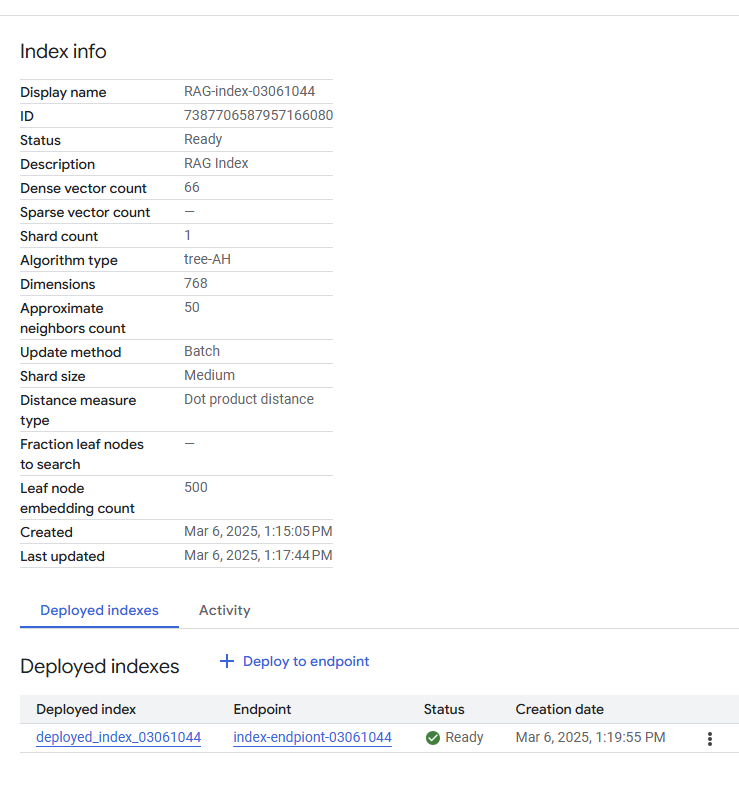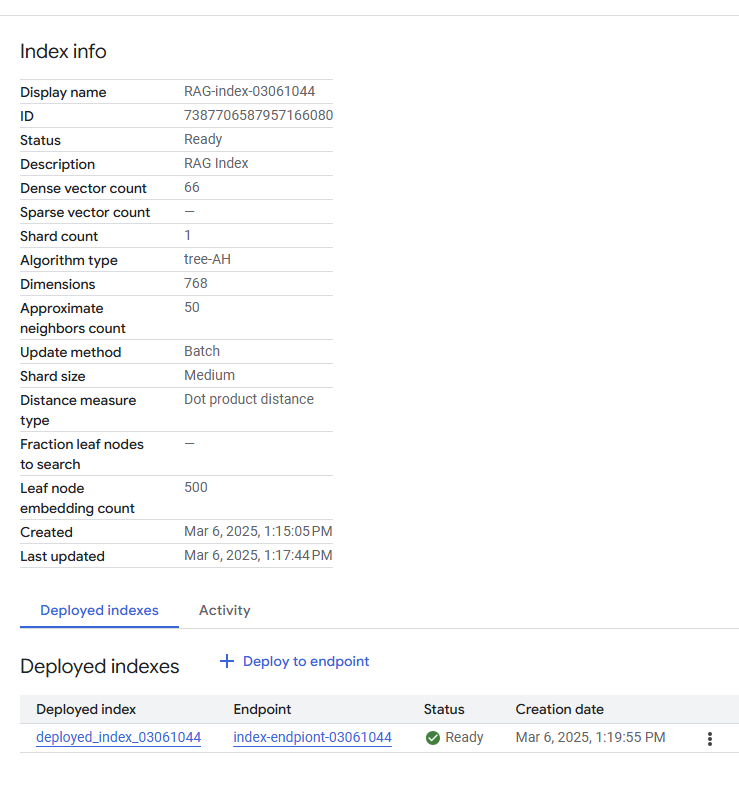

## Perform a similarity search

Retrieve the index of nearest neighbours

In [33]:
# Create the index endpoint instance from an existing endpoint.
vvs_index_endpoint = aiplatform.MatchingEngineIndexEndpoint(
    index_endpoint_name= f"projects/{PROJECT_ID}/locations/{REGION}/indexEndpoints/1323662466260926464"
)


In [57]:
def embed_query(text: str, task: str="RETRIEVAL_DOCUMENT", model_name: str="textembedding-gecko@003"):
    model = TextEmbeddingModel.from_pretrained(model_name)
    input = TextEmbeddingInput(text,task)
    embeddings = model.get_embeddings([input])
    return embeddings[0].values

# write a query and convert it to embedding
query_text = "How might cannamon supplementation interact with other dietary of lifestyle interventions for prediabetes management?"
query_embedding = embed_query(query_text)
DEPLOYED_INDEX_ID = "deployed_index_03061044"
response = vvs_index_endpoint.find_neighbors(
    deployed_index_id = DEPLOYED_INDEX_ID,
    queries=[query_embedding],
    num_neighbors=3 # change if needed
)


In [41]:
print(response) # index of close neighbours

[[MatchNeighbor(id='25', distance=0.8398637771606445, sparse_distance=None, feature_vector=[], crowding_tag='0', restricts=[], numeric_restricts=[], sparse_embedding_values=[], sparse_embedding_dimensions=[]), MatchNeighbor(id='63', distance=0.8252013325691223, sparse_distance=None, feature_vector=[], crowding_tag='0', restricts=[], numeric_restricts=[], sparse_embedding_values=[], sparse_embedding_dimensions=[]), MatchNeighbor(id='39', distance=0.8236956596374512, sparse_distance=None, feature_vector=[], crowding_tag='0', restricts=[], numeric_restricts=[], sparse_embedding_values=[], sparse_embedding_dimensions=[])]]


## Convert index of the close neighbours to Embeddings

In [46]:
neighbor_id = response[0][0].id
neighbor_embedding = vvs_index_endpoint.read_index_datapoints(deployed_index_id=DEPLOYED_INDEX_ID, ids=[neighbor_id],)
# print(neighbor_embedding)

## Convert Embeddings to texts

In [49]:
neighbor_ids = [neighbor.id for neighbor in response[0]]

def fetch_text_chunks(ids, filename=filename):
    texts = {}
    with open(filename, 'r') as file:
        for line in file:
            data=json.loads(line)
            if str(data['id']) in ids: # Ensure the id from JSON is treated as a string for matching
                texts[str(data['id'])] = data['text']
    return [texts[id] for id in ids if id in texts]

neighbor_texts = fetch_text_chunks([str(id) for id in neighbor_ids],filename=filename)

print(neighbor_texts)

['# Effect of cinnamon spice on continuously monitored glycemic response in adults with prediabetes: a 4-week randomized controlled crossover trial\n\n## CGM\n\n### TABLE 1\n\nBaseline characteristics of the study participants', '# Appendix A. Supplementary data\n\n## References\n\n### H. Zelicha et al.\n\n[54] M.L. Silva, M.A. Bernardo, J. Singh, M.F. de Mesquita, Cinnamon as a complementary therapeutic approach for dysglycemia and dyslipidemia control in type 2 diabetes mellitus and its molecular mechanism of action: a review, Nutrients 14 (13) (2022) 2773. [55] Q.Y. Lu, P.H. Summanen, R.P. Lee, J. Huang, S.M. Henning, D. Heber, et al., Prebiotic potential and chemical composition of seven culinary spice extracts, J Food Sci 82 (8) (2017) 1807-1813. [56] Q.Y. Lu, A.M. Rasmussen, J. Yang, R.P. Lee, J. Huang, P. Shao, et al., Mixed spices at culinary doses have prebiotic effects in healthy adults: A pilot study, Nutrients 11 (6) (2019).', '# Effect of cinnamon spice on continuously mon

## Use results with Gemini
At this point, we pass the nearest neighbors that were found above to Gemini to compose an actual answer to the user's question.

In [61]:
import vertexai
from vertexai.generative_models import GenerativeModel, ChatSession

vertexai.init(project=PROJECT_ID, location= REGION)
model = GenerativeModel(model_name="gemini-1.0-pro-002")
chat = model.start_chat()

def get_chat_response(chat: ChatSession, prompt:str)->str:
    text_response = []
    responses = chat.send_message(prompt, stream=True)
    for chunk in responses:
        text_response.append(chunk.text)
    return "".join(text_response)
    

## Try without context

In [62]:
prompt = query_text
print(get_chat_response(chat,prompt))

## Cinnamon supplementation and its potential interaction with other dietary or lifestyle interventions for prediabetes management. 

 Cinnamon has been studied for its potential role in managing prediabetes, and research suggests it may offer some benefits when combined with other lifestyle interventions. However, it's crucial to understand how it interacts with other dietary or lifestyle changes to ensure a safe and effective approach.

**Possible interactions with dietary interventions:**

* **Fiber:** Cinnamon is a good source of fiber, which can help regulate blood sugar levels. Combining cinnamon with other high-fiber foods, such as fruits, vegetables, and whole grains, could enhance its blood sugar-lowering effects.
* **Carbohydrates:** Consuming cinnamon with high-carbohydrate meals may help slow down the absorption of sugar into the bloodstream, potentially reducing blood sugar spikes.
* **Fats:** Some studies suggest that cinnamon may be more effective in lowering blood sugar

## Try with context

Response will be based on the context provided to Gemini

In [65]:
prompt = f"{query_text} in the context of :{neighbor_texts}"
print(get_chat_response(chat,prompt))

## Cinnamon Supplementation and Interaction with Dietary and Lifestyle Interventions for Prediabetes Management: Insights from the Provided Context

Based on the provided context, including the research article "Effect of cinnamon spice on continuously monitored glycemic response in adults with prediabetes: a 4-week randomized controlled crossover trial," the effect of cinnamon supplementation on prediabetes management seems promising, especially when combined with other dietary and lifestyle interventions.

**Here's how cinnamon interacts with specific dietary and lifestyle interventions:**

**Dietary Interventions:**

* **Fiber:** The study participants received a high-fiber meal standardized for individual fiber intake. This suggests that the observed positive effects of cinnamon on glycemic response were likely enhanced by the presence of fiber.
* **Carbohydrates:** The meal contained a moderate amount of carbohydrates (50g). Cinnamon might be more effective in controlling postpran

## Try only from context

In [66]:
prompt = f"{query_text} answer only from the following context :{neighbor_texts}"
print(get_chat_response(chat,prompt))

## Analyzing the context to understand cinnamon's interaction with other interventions for prediabetes:

From the provided context, focusing solely on the research article titled "Effect of cinnamon spice on continuously monitored glycemic response in adults with prediabetes: a 4-week randomized controlled crossover trial," we can glean some insights into cinnamon's interactions with other dietary and lifestyle interventions for managing prediabetes:

**Key Takeaways:**

* **Cinnamon's positive effect:** The study clearly demonstrates that cinnamon supplementation (6g daily) can significantly improve postprandial glycemic response in adults with prediabetes compared to placebo. This suggests a potential benefit of adding cinnamon to other management strategies.
* **Combined with high-fiber meal:** Notably, the study participants received a high-fiber meal standardized for individual fiber intake. This implies that the observed positive effect of cinnamon might be amplified by the prese

## Clean up GCP environment

In [70]:
to_clean = True

In [ ]:
from google.api_core import exceptions as gcp_exceptions

if to_clean:
    try:
        client.delete_processor(name=processor_name)
        print(f"Deleted Processor: {processor_name}")
    except gcp_exceptions.NotFound:
        print(f"Processor not found: {processor_name}")
else:
    print("clean_up parameter is set to False")

## Delete Vector Search Index

In [72]:
if to_clean:
    try:
        vvs_index.delete()
        print(f"Deleted Matching Engine Index: {vvs_index.resource_name}")
    except gcp_exceptions.NotFound:
        print(f"Index not found: {vvs_index.resource_name}")
    except Exception as e:
        print(f"Error deleting index: {e}")
else:
    print("clean_up parameter is set to False")

Error deleting index: name 'vvs_index' is not defined


## Delete the deployed endpoint

In [73]:
from google.api_core import exceptions

if to_clean:
    try:
        # Undeploy the deployed index
        try:
            vvs_index_endpoint.undeploy_index(deployed_index_id=DEPLOYED_INDEX_ID)
            print(f"Undeployed index '{DEPLOYED_INDEX_ID}' from endpoint '{vvs_index_endpoint.name}'.")
        except exceptions.NotFound:
            print(f"Deployed index '{DEPLOYED_INDEX_ID}' not found in endpoint '{vvs_index_endpoint.name}'.")

        # Delete the index endpoint
        vvs_index_endpoint.delete()
        print(f"Deleted index endpoint: {vvs_index_endpoint.name}")

    except exceptions.NotFound:
        print(f"Index endpoint not found: {vvs_index_endpoint.name}")
else:
    print("clean_up parameter is set to False")

Undeploying index MatchingEngineIndexEndpoint index_endpoint: projects/200042228144/locations/europe-west1/indexEndpoints/1323662466260926464
Undeploy index MatchingEngineIndexEndpoint index_endpoint backing LRO: projects/200042228144/locations/europe-west1/indexEndpoints/1323662466260926464/operations/8989650224527966208
MatchingEngineIndexEndpoint index_endpoint Undeployed index. Resource name: projects/200042228144/locations/europe-west1/indexEndpoints/1323662466260926464
Undeployed index 'deployed_index_03061044' from endpoint '1323662466260926464'.
Deleting MatchingEngineIndexEndpoint : projects/200042228144/locations/europe-west1/indexEndpoints/1323662466260926464
MatchingEngineIndexEndpoint deleted. . Resource name: projects/200042228144/locations/europe-west1/indexEndpoints/1323662466260926464
Deleting MatchingEngineIndexEndpoint resource: projects/200042228144/locations/europe-west1/indexEndpoints/1323662466260926464
Delete MatchingEngineIndexEndpoint backing LRO: projects/200

## Delete bucket

- Bucket location: https://console.cloud.google.com/storage/

In [74]:
if to_clean == True:
    # Delete the bucket
    ! gcloud storage rm --recursive gs://$BUCKET
else:
    print("delete_bucket parameter is set to False")

Removing objects:
Removing gs://llmops-452409-bucket/embeddings-data-03061044/batch_root/embeddings03061044.json#1741262308547101...
  Completed 1/1                                                                
Removing buckets:
Removing gs://llmops-452409-bucket/...                                         
  Completed 1/1                                                                
